In [11]:
import numpy as np
import pandas as pd
import seaborn as sb
sb.set()
import scipy.optimize as optimization
from datetime import datetime, timedelta
from matplotlib import rcParams
rcParams['figure.figsize'] = 10,6
import math
import scipy.stats
import matplotlib.pyplot as plt
import time
from ipywidgets import Checkbox

In [2]:
class MarkowitzPortfolioSimulation:
    
    def __init__(self, df, iterations):
        
        self.df = df
        self.iterations = iterations
        self.N = None
        self.returns = None
        self.volatility = None
        self.results = None

    def calculate_log_rets(self):
        
        # calculate logaritmic daly change of all asets
        log_rets = np.log(1 + df.pct_change(1)).dropna()
        return log_rets
    
    def calculate_N(self):
        
        # Quantity of stock in portfolio
        N = len(df.columns)
        return N
    
    def gen_weights(self):
        
        # generate N random weights, where N is quantity of stocks that user has choesen previosly
        N = self.calculate_N()
        weights = np.random.random(N)
        return weights / np.sum(weights)
    
    def calculate_returns(self, weights, log_rets):
        # Calculate logaritmic returns for given weights
        returns = np.sum(log_rets.mean()*weights) * 365
        return returns
    
    def calculate_volatility(self, weights, log_rets):
        
        # We uce covariance instead of log_rets
        log_rets_cov = log_rets.cov()
        
        # Calc annual covariance for given weight
        annualized_cov = np.dot(log_rets_cov*365, weights)
        # Use covariance to calculate volotality and std
        vol = np.dot(weights.transpose(),annualized_cov)
        volatility = np.sqrt(vol)
        
        return volatility
    
    def symulatePortfoliosWeights(self):        
        
        # Chceck how many stock been choesen
        N = self.calculate_N()
        # calcl log rets using previos function
        log_rets = self.calculate_log_rets()
        
        # For markowitz portfolio we count this 3 features
        portfolio_returns = []
        portfolio_vol = []
        portfolio_weights = []

        # generate portfolios with different weights and calculate volotality and returns
        # iteration means how many portfolio we want to generate
        for sim in range(iterations):

            weights = self.gen_weights()
            portfolio_weights.append(weights)

            sim_returns = self.calculate_returns(weights, log_rets)
            portfolio_returns.append(sim_returns)

            sim_vol = self.calculate_volatility(weights, log_rets)
            portfolio_vol.append(sim_vol)
            
        # Create DF wieth all calculated features
        results = pd.DataFrame({'weights':portfolio_weights, 'volatility':portfolio_vol, 'returns':portfolio_returns})
        
        return results, np.array(portfolio_returns), np.array(portfolio_vol), np.array(portfolio_weights)
    
def createResultsPlot(results):

    # We want to plot volotality and return calculated base on diff weights
    portfolio_vol = results['volatility']
    portfolio_returns = results['returns']
    # Calculate sharp ratio by divideing returns by volotality
    sharpe_ratios = portfolio_returns / portfolio_vol

    plt.figure(dpi=100,figsize=(10,5))
    plt.scatter(portfolio_vol,portfolio_returns,c=sharpe_ratios)
    plt.ylabel('EXPECTDE RETS')
    plt.xlabel('EXPECTED VOL')

    plt.colorbar(label="SHARPE RATIO");
    plt.title('Markowitz model symulation plot')

    plot = plt.show()

    return plot
    

In [3]:
def findHighestSharpRatio(results):

    # Calculate portfolio with highest sharp ratio
    portfolio_vol = results['volatility']
    portfolio_returns = results['returns']    
    sharpe_ratios = portfolio_returns / portfolio_vol

    maxSR = sharpe_ratios.max()
    maxSRPosition = sharpe_ratios.argmax()
    expected_vol = portfolio_vol[maxSRPosition]
    expected_ret = portfolio_returns[maxSRPosition]
    new_weights = results['weights'].iloc[maxSRPosition]

    print(f'The highest sharp ratio for selected assets is {round(maxSR,4)}')
    print(f'Expected logaritmic annual return: {round(expected_ret,4)}')
    print(f'Expected annual volatility: {round(expected_vol,4)}')
    print(f'Weights of wallet: {new_weights}')


    return maxSR, expected_vol, expected_ret, new_weights

In [4]:
def findBestWeightsByMaxVol(results, max_vol_yearly):

    # find the best portfolio base on max acceptable volotality for user
    # min is 0.98% of max in case that there will not be any portfolios equal to max acceptable vol
    volrange = results[(results['volatility']>max_vol_yearly*0.98) & (results['volatility']<=max_vol_yearly)]
    
    # In case the vallet does not generate that vol range or it is just not posible to get from this assets:
    if len(volrange) == 0:

        print(f'The volatility you selected {max_vol_yearly} is too low or too high. Try selecting again. Make sure the volatility is within the range of volatility shown in the chart above. ')

    else:
        
        # There might be few wallets in that range, so in that case choese the most profitable of them
        maxProfit = volrange['returns'].max()
        # Take the position of portfolio with highest annual return
        maxProfitPosition = volrange['returns'].argmax()
        # Take weights of them
        bestWeights = volrange['weights'].iloc[maxProfitPosition]
        # returns
        my_rets = volrange['returns'].iloc[maxProfitPosition]
        # volotality
        my_vol = volrange['volatility'].iloc[maxProfitPosition]
        # sh
        sharpRatio = my_rets / my_vol

        print(f'The best portfolio consistent with the assumed annual volatility can achieve an average log return of {round(maxProfit*100,2)}%')
        print(f'Proposed portfolio weights: {bestWeights}')
        print(f'Expected sharp ratio: {sharpRatio}')

    return my_rets, my_vol, sharpRatio, bestWeights

In [26]:
def createResultsPlot2(results):

    # Same plot as before but we add star sign where the highest Sharp ratio portfolio is
    portfolio_vol = results['volatility']
    portfolio_returns = results['returns']
    sharpe_ratios = portfolio_returns / portfolio_vol

    plt.figure(dpi=100,figsize=(10,5))
    plt.scatter(portfolio_vol,portfolio_returns,c=sharpe_ratios)
    plt.ylabel('EXPECTDE RETS')
    plt.xlabel('EXPECTED VOL')
    plt.title('Markowitz model symulation plot with highest Sharp Ratio')


    try:
        # best sharp ratio by max sharpratio
        plt.plot(expected_vol, expected_ret, 'g*', markersize=15.0)
    except:
        pass

    plt.colorbar(label="SHARPE RATIO");
    plot = plt.show()

    return plot

In [6]:
def createResultsPlot3(results):
    
    # Same as previos but we add also our choesen max vol condition portfolio 
    portfolio_vol = results['volatility']
    portfolio_returns = results['returns']
    sharpe_ratios = portfolio_returns / portfolio_vol

    plt.figure(dpi=100,figsize=(10,5))
    plt.scatter(portfolio_vol,portfolio_returns,c=sharpe_ratios)
    plt.ylabel('EXPECTDE RETS')
    plt.xlabel('EXPECTED VOL')
    plt.title('Markowitz model symulation plot with highest Sharp Ratio and max risk aversion')


    # best sharp ratio by max sharpratio
    plt.plot(expected_vol, expected_ret, 'g*', markersize=15.0)
    
    # max vol portfolio with blue star
    plt.plot(my_vol, my_rets, 'g*', markersize=20.0, color='blue')

    plt.colorbar(label="SHARPE RATIO");
    plot = plt.show()

    return plot

In [7]:
def create_summary(maxSR, sharpRatio, expected_vol, my_vol, expected_ret, my_rets, new_weights, bestWeights):
    
    # Create summary of 2 types of wallet:
    # 1. Max sharp-ratio calculated by markowitz model
    # 2. Best return portfolio by max volotality
    df = pd.DataFrame({'Wallet': ['Highest Sharp Ratio', 'My Choice'], 'Sharp Ratio': [maxSR, sharpRatio]
                  , 'Expected volatility':[expected_vol, my_vol]
                  , 'Expected log return': [expected_ret, my_rets]
                  , 'Wallet weights' : [new_weights, bestWeights]
                 })
    df.set_index('Wallet', inplace=True)
    
    return df

In [8]:
# Create checkbox values
# User can choose highest sharp ratio wallet weights or weights selected by max vol
HighestSR= Checkbox(description = 'Highest Sharp Ratio')
MyWallet = Checkbox(description = 'My Choice')

def choese_wallet(HighestSR, MyWallet):
    tickers = [HighestSR, MyWallet]
    choesen_wallet = []

    for ticker in tickers:

        if ticker.get_interact_value() == True:
            ticker_name = ticker.description
            choesen_wallet.append(ticker_name)

        else:
            pass

    # Condition: User must select 1 of the wallet
    if len(choesen_wallet) == 0:
        print('You must select at least 1 wallet in analyse perpouse')
    
    elif len(choesen_wallet) > 1:
        print('You CAN NOT select more than 1 wallet in analyse perpouse')
        
    else: 
        print(f'Your choice: {choesen_wallet}')
        
    return choesen_wallet

In [9]:
# save choesen weights for future analysis
def create_and_save_wallet_weightsDataFrame(summary, tickers, df):

    choice = summary['Wallet weights'].loc[tickers].values
    choice = choice[0].astype(float)
    wallet = pd.Series(choice).astype(str).str.split(expand=True).T
    wallet.columns = df.columns
    wallet.to_csv('DATA/choesenWallet.csv')
    
    return wallet

### 1. Download prepared data

In [13]:
df = pd.read_csv('../DATA/PrepData.csv')

df['Date'] = pd.to_datetime(df['Date'])

df.set_index('Date', inplace=True)

In [11]:
#df = df.drop('BTC-USD', axis=1)

### 2. Choese iterations

In [14]:
# How many portfolio you want to simulate
iterations = 30000

### 3. Call function and get simulation of portolio

In [15]:
results, returns, vol, weights = MarkowitzPortfolioSimulation(df, iterations).symulatePortfoliosWeights()

### 4. See results on plot

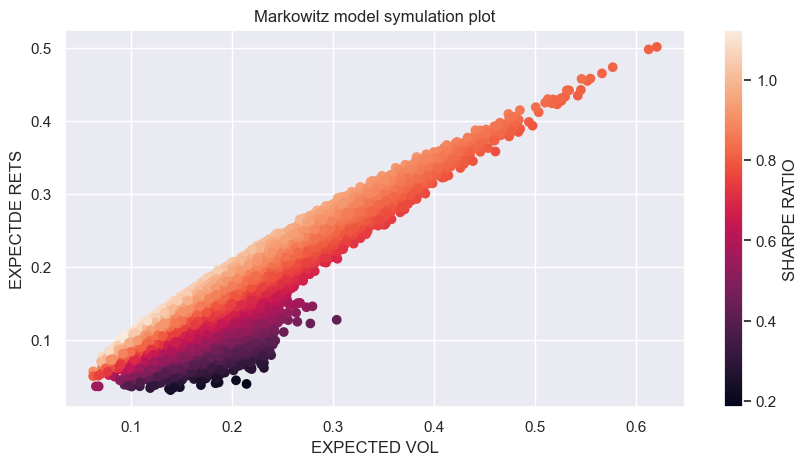

In [16]:
createResultsPlot(results)

### 5. Find portfolio with highest Sharp Ratio

In [17]:
maxSR, expected_vol, expected_ret, new_weights = findHighestSharpRatio(results)

The highest sharp ratio for selected assets is 1.1258
Expected logaritmic annual return: 0.1041
Expected annual volatility: 0.0924
Weights of wallet: [0.09003783 0.30123036 0.57066099 0.0099591  0.02811173]


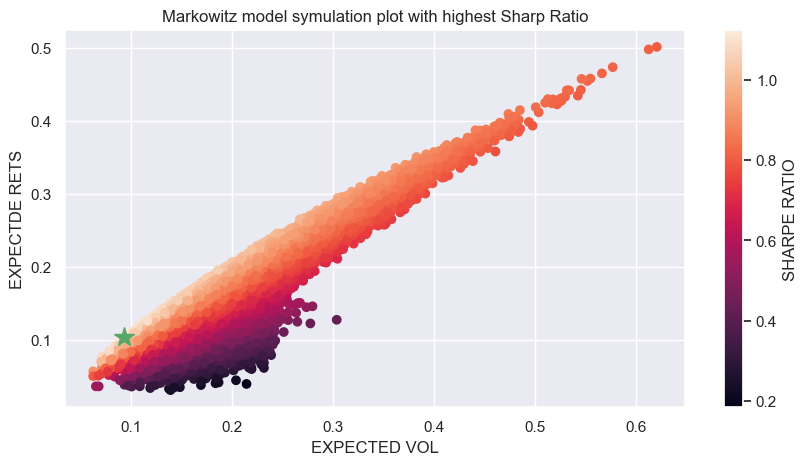

In [27]:
createResultsPlot2(results)

### 6. Find weights for aceptable log returns volatility

In [28]:
max_vol_yearly = 0.35

In [29]:
my_rets, my_vol, sharpRatio, bestWeights = findBestWeightsByMaxVol(results, max_vol_yearly)

The best portfolio consistent with the assumed annual volatility can achieve an average log return of 32.5%
Proposed portfolio weights: [0.4376914  0.48316895 0.02575953 0.00997754 0.04340258]
Expected sharp ratio: 0.9330674630490478


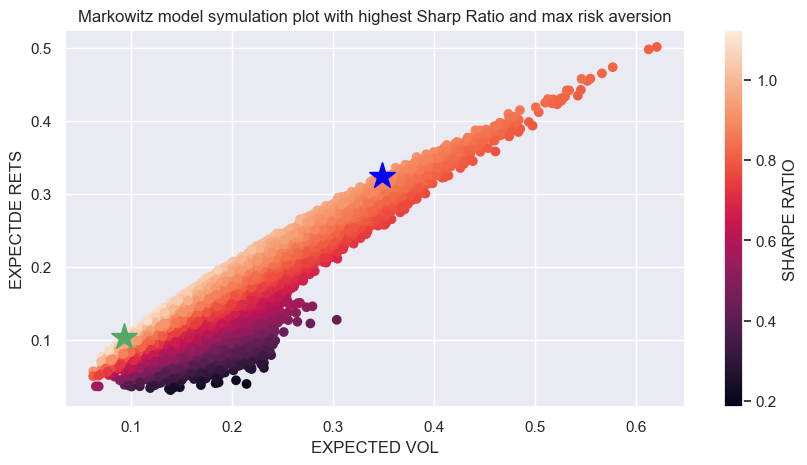

In [30]:
createResultsPlot3(results)

## 7. Summary

In [20]:
summary = create_summary(maxSR, sharpRatio, expected_vol, my_vol, expected_ret, my_rets, new_weights, bestWeights)
summary

,Sharp Ratio,Expected volatility,Expected log return,Wallet weights
Wallet,,,,
Highest Sharp Ratio,1.131969,0.086046,0.097401,"[0.08058448924072267, 0.3123858513686191, 0.59..."
My Choice,0.933820,0.347459,0.324464,"[0.43484170696934993, 0.450561157915836, 0.021..."


### 8. Select a portfolio for further analysis

In [21]:
display(HighestSR, MyWallet)

Checkbox(value=False, description='Highest Sharp Ratio')

Checkbox(value=False, description='My Choice')

In [22]:
tickers = choese_wallet(HighestSR, MyWallet)

You must select at least 1 wallet in analyse perpouse


In [23]:
create_and_save_wallet_weightsDataFrame(summary, tickers, df).T

IndexError: index 0 is out of bounds for axis 0 with size 0

## Next Step

**Now, when you choese your best fitted portfolio You shoul get into it. Here we worked on logaritmic returns and volotality, but in real life you will care about simple returns. Also what could be more important to you instead of volotality is dropdawns, which could be dengerous and could lead to bad invetment decisions. Let's comapre your portfolio with equal weighted one and see what u can expect base on historical data.** [Link](http://localhost:8888/notebooks/ModernPortfolio_project/6.%20CompareNewPortfolioWithEqualWeightedPortfolio.ipynb)  